###Libraries

In [1]:
# !pip3 install catboost

In [2]:
import collections
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from catboost import CatBoostClassifier
# from imblearn.over_sampling import RandomOverSampler
# from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
# from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
# from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
from xgboost import XGBClassifier

### Loading and Transforming Data

In [3]:
files = glob.glob("*.csv")  # please put all files, Train and Unseen, in the root folder
files.sort()
dfs = []
for file in files:
    dfs.append(pd.read_csv(file))

In [4]:
len(dfs)

8

In [5]:
files

['Train-1542865627584.csv',
 'Train_Beneficiarydata-1542865627584.csv',
 'Train_Inpatientdata-1542865627584.csv',
 'Train_Outpatientdata-1542865627584.csv',
 'Unseen-1542969243754.csv',
 'Unseen_Beneficiarydata-1542969243754.csv',
 'Unseen_Inpatientdata-1542969243754.csv',
 'Unseen_Outpatientdata-1542969243754.csv']

Let"s not make too many intermediate DataFrames in the interest of time. Let"s make training and testing datasets before cleaning.

In [6]:
dfs[0].head()

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


In [7]:
dfs[0]["PotentialFraud"].value_counts()

,count
PotentialFraud,
No,4904
Yes,506


In [8]:
dfs[1].head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,1,2,2,2,2,0,0,1790,1200


In [9]:
dfs[2].head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [10]:
dfs[3].head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [11]:
dfs[2].shape

(40474, 30)

In [12]:
dfs[3].shape

(517737, 27)

In [13]:
unique_cols_inpatient = set(dfs[2].columns) - set(dfs[3].columns)
unique_cols_inpatient

{'AdmissionDt', 'DiagnosisGroupCode', 'DischargeDt'}

In [14]:
unique_cols_outpatient = set(dfs[3].columns) - set(dfs[2].columns)
unique_cols_outpatient

set()

In [15]:
percent_inpatients = len(dfs[2])*100 / (len(dfs[2]) + len(dfs[3]))
print(f"Percentage of inpatients: {percent_inpatients:.2f}%")

Percentage of inpatients: 7.25%


Given that the vast majority of patients are outpatients, we are going to ignore the columns of the inpatients for the overall training, although admission length might be a valuable feature. A single flag calling a patient "Inpatient" and "Outpatient" should hopefully account for the data in these columns.

In [16]:
dfs[2]["BeneType"] = "Inpatient"
dfs[3]["BeneType"] = "Outpatient"

In [17]:
df_patients = pd.concat([dfs[2].drop(columns=unique_cols_inpatient), dfs[3]], axis=0)
df_patients.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,...,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,BeneType
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,7866,...,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,6186,...,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,Inpatient
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,29590,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,431,...,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,Inpatient
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,78321,...,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,Inpatient


In [18]:
df_patients["Provider"].nunique()

5410

In [19]:
len(dfs[0])

5410

In [20]:
dfs[0]["Provider"].nunique()

5410

In [21]:
df_patients["BeneID"].nunique()

138556

In [22]:
len(dfs[1])

138556

Let"s construct the training dataset by merging benefactor and provider information, given that they appear to be keys

In [23]:
df_train = df_patients.merge(dfs[1], how="left", on="BeneID").merge(dfs[0], how="left", on="Provider").reset_index(drop=True)
df_train.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,7866,...,1,1,2,1,1,36000,3204,60,70,Yes
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,6186,...,1,1,2,1,1,36000,3204,60,70,No
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,29590,...,1,1,2,1,1,36000,3204,60,70,No
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,431,...,1,2,2,1,1,5000,1068,250,320,No
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,78321,...,2,1,2,2,2,21260,2136,120,100,No


In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 53 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   ClaimID                          558211 non-null  object 
 2   ClaimStartDt                     558211 non-null  object 
 3   ClaimEndDt                       558211 non-null  object 
 4   Provider                         558211 non-null  object 
 5   InscClaimAmtReimbursed           558211 non-null  int64  
 6   AttendingPhysician               556703 non-null  object 
 7   OperatingPhysician               114447 non-null  object 
 8   OtherPhysician                   199736 non-null  object 
 9   ClmAdmitDiagnosisCode            145899 non-null  object 
 10  DeductibleAmtPaid                557312 non-null  float64
 11  ClmDiagnosisCode_1               547758 non-null  object 
 12  Cl

Checking to see if 'Provider' is a unique key

In [25]:
df_train['Provider'].nunique()

5410

In [26]:
len(dfs[0])

5410

The potential fraud is provided on a provider level, not a claim level. We need to perform our predictions on a claim level.

### Exploratory Data Analysis

In [27]:
df_plot = df_train.copy()
df_plot.loc[df_plot["PotentialFraud"] == "No", "PotentialFraud"] = 0
df_plot.loc[df_plot["PotentialFraud"] == "Yes", "PotentialFraud"] = 1
df_plot["PotentialFraud"] = df_plot["PotentialFraud"].astype("int64")

# transforming some columns to categorical
cols_code = [col for col in df_plot.columns if "Code" in col]
df_plot[cols_code + ["State", "County"]] = df_plot[cols_code + ["State", "County"]].astype(str)

In [28]:
correlation_matrix = df_plot.select_dtypes("number").corr()

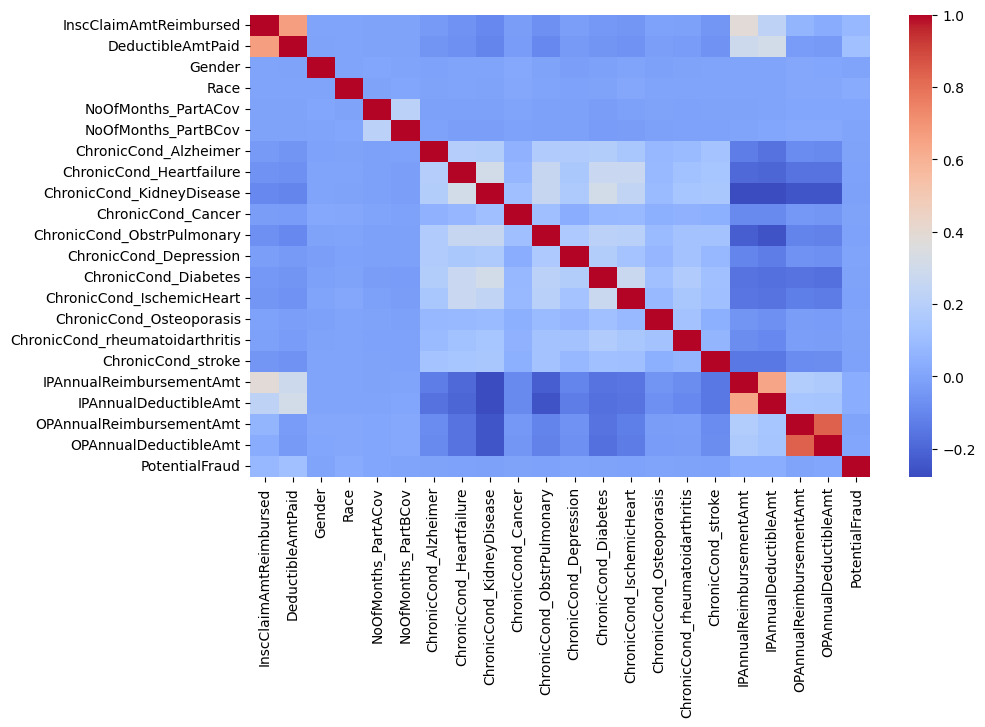

In [29]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.show()

No real significant correlations other than natural ones like reimbursement/deductible amounts. No strong correlation with PotentialFraud.

In [30]:
df_plot["PotentialFraud"].value_counts()

,count
PotentialFraud,
0,345415
1,212796


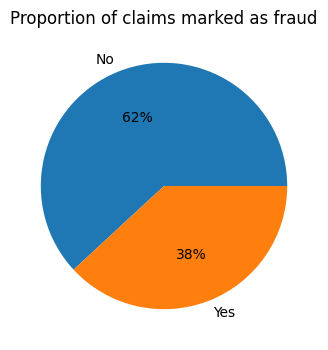

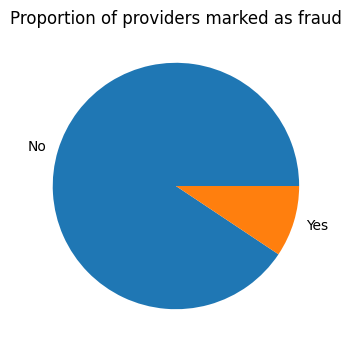

In [31]:
plt.figure(figsize=(6, 4))
plt.pie(df_plot["PotentialFraud"].value_counts(), labels=["No", "Yes"], autopct='%1.0f%%')
plt.title("Proportion of claims marked as fraud")

plt.show()
print()
plt.figure(figsize=(6, 4))
plt.pie(dfs[0]["PotentialFraud"].value_counts(), labels=["No", "Yes"])
plt.title("Proportion of providers marked as fraud")
plt.show()

In the dataset, the proportion of claims marked as fraud are around 38%, while the number of providers marked as fraud are around 9%. This tells us that the dataset is biased to feature more claims by likely fraudster providers. The goal must then be to try to extract other information such as benefactor, physician, and code information from these fraud claims.

In [32]:
df_plot.loc[df_plot["PotentialFraud"]==1, :]

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,7866,...,1,1,2,1,1,36000,3204,60,70,1
5,BENE11017,CLM70950,2009-10-06,2009-10-12,PRV54986,8000,PHY402711,PHY402711,PHY402711,1749,...,1,1,2,1,1,22000,2136,1400,840,1
7,BENE11028,CLM62376,2009-08-03,2009-08-07,PRV51148,6000,PHY346286,PHY405514,NaN,78605,...,1,1,1,2,2,6000,1068,0,0,1
9,BENE11034,CLM31519,2008-12-29,2009-01-05,PRV55215,29000,PHY355604,PHY415867,NaN,41401,...,1,1,2,1,1,131140,2136,1650,80,1
10,BENE11034,CLM57949,2009-07-01,2009-07-09,PRV55193,102000,PHY397979,PHY418257,NaN,78605,...,1,1,2,1,1,131140,2136,1650,80,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558191,BENE159196,CLM643605,2009-10-22,2009-10-22,PRV51836,30,PHY433436,NaN,PHY313818,nan,...,1,1,2,2,2,2000,1068,3240,1390,1
558193,BENE159196,CLM676496,2009-11-11,2009-11-11,PRV51836,100,PHY433436,NaN,PHY313818,nan,...,1,1,2,2,2,2000,1068,3240,1390,1
558194,BENE159196,CLM684528,2009-11-16,2009-11-16,PRV51851,60,PHY344222,PHY344222,PHY370416,nan,...,1,1,2,2,2,2000,1068,3240,1390,1
558195,BENE159196,CLM721301,2009-12-09,2009-12-09,PRV51836,800,PHY376936,NaN,PHY313818,nan,...,1,1,2,2,2,2000,1068,3240,1390,1


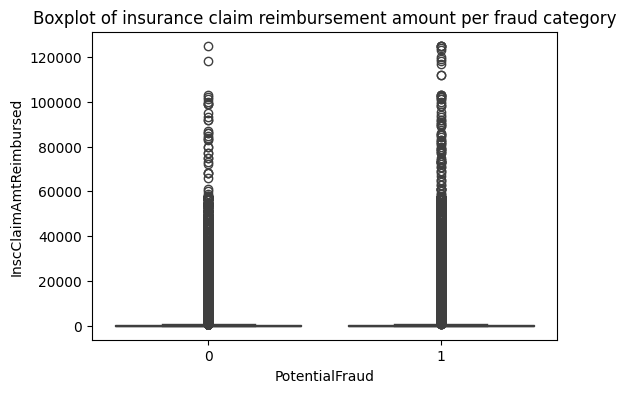

In [33]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_plot, y="InscClaimAmtReimbursed", x="PotentialFraud")
plt.title("Boxplot of insurance claim reimbursement amount per fraud category")
plt.show()

Most disbursed amounts are tiny, and there is a large outlier tail (outliers classified by IQR method).

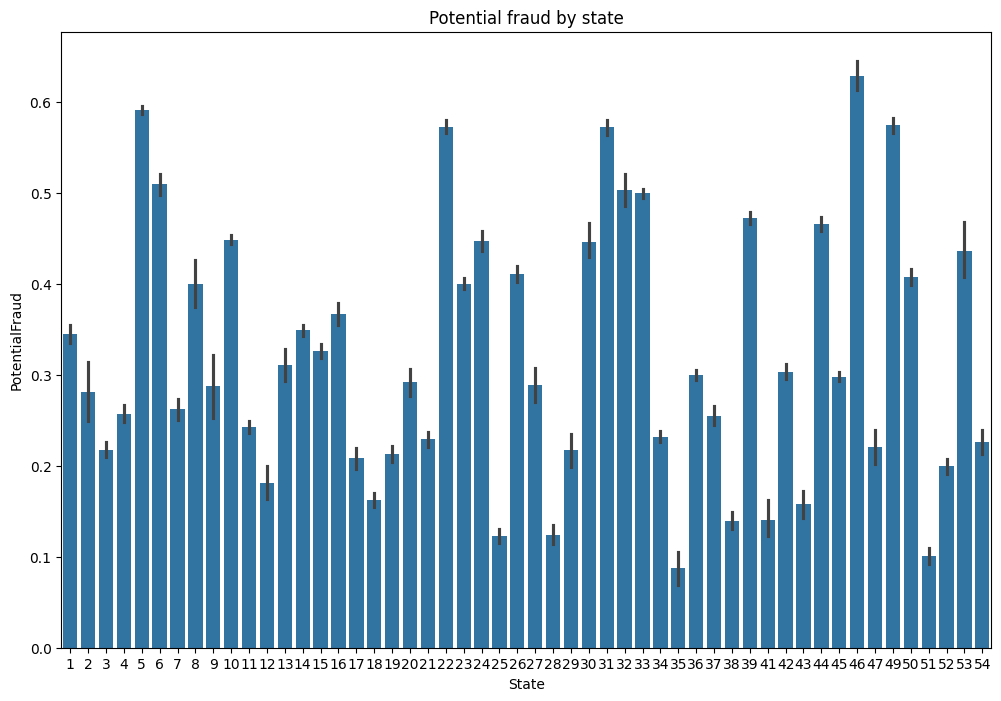

In [34]:
plt.figure(figsize=(12, 8))
sns.barplot(data=df_plot, x="State", y="PotentialFraud", order=df_plot["State"].astype(int).sort_values().astype(str).unique())
plt.title("Potential fraud by state")
plt.show()

Likelihood of fraud by state reveals that the state numbered 46 has the highest likelihood of fraud and/or that this state is highly represented in the database.

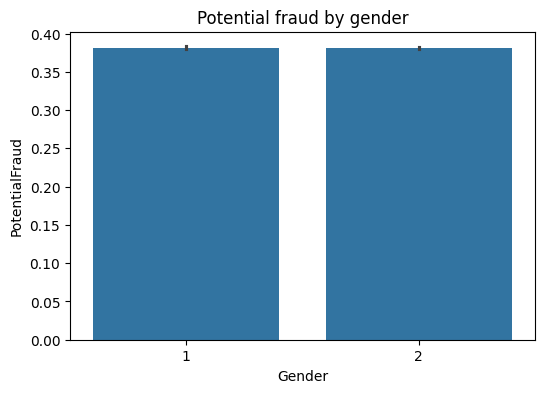

In [35]:
plt.figure(figsize=(6, 4))
sns.barplot(data=df_plot, x="Gender", y="PotentialFraud")
plt.title("Potential fraud by gender")
plt.show()

### Data Cleaning and Feature Engineering

In [36]:
df_train.shape

(558211, 53)

In [37]:
len(df_train["ClaimID"].unique())

558211

Therefore, we are considering the claims to be the index for our table.

In [38]:
df_train.set_index("ClaimID", inplace=True)

In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 558211 entries, CLM46614 to CLM686139
Data columns (total 52 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   ClaimStartDt                     558211 non-null  object 
 2   ClaimEndDt                       558211 non-null  object 
 3   Provider                         558211 non-null  object 
 4   InscClaimAmtReimbursed           558211 non-null  int64  
 5   AttendingPhysician               556703 non-null  object 
 6   OperatingPhysician               114447 non-null  object 
 7   OtherPhysician                   199736 non-null  object 
 8   ClmAdmitDiagnosisCode            145899 non-null  object 
 9   DeductibleAmtPaid                557312 non-null  float64
 10  ClmDiagnosisCode_1               547758 non-null  object 
 11  ClmDiagnosisCode_2               362605 non-null  object 
 1

Let"s find the missing percentage of each column.

In [40]:
df_missing_percent = pd.DataFrame({"Missing %": df_train.isna().sum()*100/len(df_train)}, index=df_train.columns)
df_missing_percent

,Missing %
BeneID,0.000000
ClaimStartDt,0.000000
ClaimEndDt,0.000000
Provider,0.000000
InscClaimAmtReimbursed,0.000000
AttendingPhysician,0.270149
OperatingPhysician,79.497538
OtherPhysician,64.218548
ClmAdmitDiagnosisCode,73.863109
DeductibleAmtPaid,0.161050


Let"s deal with the columns step-by-step:

#### Code and Physician Columns

Admit diagnosis, diagnosis, and procedure codes seem like categoricals. Furthermore, for the latter two, there is a sequential falloff in null values. The patients may have multiple different diagnoses. Let"s target this first as it"s the hardest bunch of columns to deal with. Features we can engineer out of these:

*   Count of number of diagnoses per claim
*   Count of number of procedures per claim
*   Check to see if any admit diagnoses and diagnoses match
*   One-hot-encoding of most common admit diagnoses; most common admit diagnoses where fraud was detected
*   One-hot-encoding of most common diagnoses; most common diagnoses where fraud was detected
*   One-hot-encoding of most common procedures; most common procedures where fraud was detected

Similarly for physicians:

*   Count of number of physicians per claim
*   Check to see if any of the physicians (attending, operating, other) match
*   One-hot-encoding of most common physicians
*   One-hot-encoding of most common physicians where fraud was detected, most common physicians where fraud was detected

Then we can drop the columns

In [41]:
cols_code = [col for col in df_train.columns if "Code" in col]
cols_code

['ClmAdmitDiagnosisCode',
 'ClmDiagnosisCode_1',
 'ClmDiagnosisCode_2',
 'ClmDiagnosisCode_3',
 'ClmDiagnosisCode_4',
 'ClmDiagnosisCode_5',
 'ClmDiagnosisCode_6',
 'ClmDiagnosisCode_7',
 'ClmDiagnosisCode_8',
 'ClmDiagnosisCode_9',
 'ClmDiagnosisCode_10',
 'ClmProcedureCode_1',
 'ClmProcedureCode_2',
 'ClmProcedureCode_3',
 'ClmProcedureCode_4',
 'ClmProcedureCode_5',
 'ClmProcedureCode_6']

In [42]:
cols_physician = [col for col in df_train.columns if "Physician" in col]
cols_physician

['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']

In [43]:
col_admit_diagnosis = "ClmAdmitDiagnosisCode"
cols_diagnosis = [col for col in cols_code if "ClmDiagnosisCode_" in col]
cols_procedure = [col for col in cols_code if "ClmProcedureCode_" in col]

Let"s count the number of diagnoses and procedures, and if the admit diagnosis and any diagnosis matches.

In [44]:
df_train["NumDiagnosis"] = df_train[cols_diagnosis].count(axis=1)
df_train["NumProcedures"] = df_train[cols_procedure].count(axis=1)
df_train["NumPhysicians"] = df_train[cols_physician].count(axis=1)
df_train["DiagnosisMatch"] = df_train[cols_diagnosis].isin(df_train[col_admit_diagnosis]).any(axis=1)
df_train["PhysicianMatch"] = df_train[cols_physician].nunique(axis=1) < 3

Let"s verify these columns with a sample

In [45]:
df_train[cols_code + ["NumDiagnosis", "NumProcedures", "DiagnosisMatch"]].head()

,ClmAdmitDiagnosisCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,NumDiagnosis,NumProcedures,DiagnosisMatch
ClaimID,,,,,,,,,,,,,,,,,,,,
CLM46614,7866,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,0,False
CLM66048,6186,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,3,1,True
CLM68358,29590,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,0,False
CLM38412,431,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,9,1,False
CLM63689,78321,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,9,1,False


Let"s make one-hot-encoded columns for the top `n_common` most common diagnoses, admit diagnoses, and procedures. We"ll rename everything else to "Other"

In [46]:
# Converting all these columns to strings to preserve categorical nature
df_train[cols_code + cols_physician] = df_train[cols_code + cols_physician].astype(str)

In [47]:
# Parameter for how many most common codes/physicians to turn into features
# Ideally should be different per type but ignoring that for now
n_common = 10

In [48]:
all_admit_diagnosis = [code for code in list(df_train[col_admit_diagnosis].values) if code != "nan"]
unique_admit_diagnosis = set(all_admit_diagnosis)
counter_admit_diagnosis = collections.Counter(all_admit_diagnosis)

print(f"Number of unique admit diagnosis codes: {len(unique_admit_diagnosis)}")
print(f"{n_common} most common unique admit diagnosis codes: {counter_admit_diagnosis.most_common(n_common)}")

Number of unique admit diagnosis codes: 4098
10 most common unique admit diagnosis codes: [('V7612', 4074), ('42731', 3634), ('78605', 2992), ('4019', 2732), ('25000', 2368), ('78900', 2336), ('78650', 2273), ('V5883', 1873), ('7295', 1844), ('78079', 1779)]


In [49]:
all_diagnosis = [code for code in list(df_train[cols_diagnosis].values.ravel("K")) if code != "nan"]
unique_diagnosis = set(all_diagnosis)
counter_diagnosis = collections.Counter(all_diagnosis)

print(f"Number of unique diagnosis codes: {len(unique_diagnosis)}")
print(f"{n_common} most common unique diagnosis codes: {counter_diagnosis.most_common(n_common)}")

Number of unique diagnosis codes: 11014
10 most common unique diagnosis codes: [('4019', 77056), ('25000', 37356), ('2724', 35763), ('V5869', 24904), ('4011', 23773), ('42731', 20138), ('V5861', 20001), ('2720', 18268), ('2449', 17600), ('4280', 15507)]


In [50]:
all_procedure = [code for code in list(df_train[cols_procedure].values.ravel("K")) if code != "nan"]
unique_procedure = set(all_procedure)
counter_procedure = collections.Counter(all_procedure)

print(f"Number of unique procedure codes: {len(unique_procedure)}")
print(f"{n_common} most common unique procedure codes: {counter_procedure.most_common(n_common)}")

Number of unique procedure codes: 1324
10 most common unique procedure codes: [('4019.0', 1959), ('9904.0', 1152), ('2724.0', 1054), ('8154.0', 1022), ('66.0', 901), ('3893.0', 854), ('3995.0', 809), ('4516.0', 651), ('3722.0', 589), ('8151.0', 463)]


In [51]:
all_physician = [code for code in list(df_train[cols_physician].values.ravel("K")) if code != "nan"]
unique_physician = set(all_physician)
counter_physician = collections.Counter(all_physician)

print(f"Number of unique physician codes: {len(unique_physician)}")
print(f"{n_common} most common unique physician codes: {counter_physician.most_common(n_common)}")

Number of unique physician codes: 100737
10 most common unique physician codes: [('PHY330576', 2958), ('PHY412132', 2813), ('PHY341578', 2455), ('PHY337425', 2423), ('PHY350277', 2310), ('PHY338032', 2228), ('PHY347064', 2071), ('PHY415321', 1845), ('PHY423534', 1473), ('PHY314027', 1456)]


Let's also find out the most common for each of the above where "PotentialFraud" is "Yes".

In [52]:
df_fraud_yes = df_train.loc[df_train["PotentialFraud"] == "Yes"]

all_fraud_admit_diagnosis = [code for code in list(df_fraud_yes[col_admit_diagnosis].values) if code != "nan"]
counter_fraud_admit_diagnosis = collections.Counter(all_fraud_admit_diagnosis)

print(f"{n_common} most common admit diagnosis codes where potential fraud was detected: {counter_fraud_admit_diagnosis.most_common(n_common)}")

all_fraud_diagnosis = [code for code in list(df_fraud_yes[cols_diagnosis].values.ravel("K")) if code != "nan"]
counter_fraud_diagnosis = collections.Counter(all_fraud_diagnosis)

print(f"{n_common} most common diagnosis codes where potential fraud was detected: {counter_fraud_diagnosis.most_common(n_common)}")

all_fraud_procedure = [code for code in list(df_fraud_yes[cols_procedure].values.ravel("K")) if code != "nan"]
counter_fraud_procedure = collections.Counter(all_fraud_procedure)

print(f"{n_common} most common procedure codes where potential fraud was detected: {counter_fraud_procedure.most_common(n_common)}")

all_fraud_physician = [code for code in list(df_fraud_yes[cols_physician].values.ravel("K")) if code != "nan"]
counter_fraud_physician = collections.Counter(all_fraud_physician)

print(f"{n_common} most common physician codes where potential fraud was detected: {counter_fraud_physician.most_common(n_common)}")

10 most common admit diagnosis codes where potential fraud was detected: [('42731', 1529), ('V7612', 1441), ('78605', 1432), ('78650', 1191), ('78900', 1020), ('4019', 1006), ('25000', 873), ('486', 843), ('78079', 828), ('7802', 793)]
10 most common diagnosis codes where potential fraud was detected: [('4019', 31029), ('25000', 15087), ('2724', 14690), ('V5869', 9116), ('42731', 8698), ('4011', 8652), ('V5861', 7629), ('2449', 7276), ('2720', 7121), ('4280', 7115)]
10 most common procedure codes where potential fraud was detected: [('4019.0', 1139), ('2724.0', 641), ('9904.0', 634), ('8154.0', 615), ('66.0', 539), ('3893.0', 483), ('3995.0', 477), ('4516.0', 370), ('3722.0', 334), ('8151.0', 281)]
10 most common physician codes where potential fraud was detected: [('PHY330576', 2958), ('PHY412132', 2813), ('PHY341578', 2455), ('PHY337425', 2423), ('PHY350277', 2310), ('PHY338032', 2228), ('PHY347064', 2071), ('PHY415321', 1845), ('PHY423534', 1473), ('PHY314027', 1456)]


In [53]:
# Make column names for one-hot columns (most common + "Other")
one_hot_admit_diagnosis = list(set(["AdmitDiagnosis_" + pair[0] for pair in counter_admit_diagnosis.most_common(n_common)] + ["AdmitDiagnosis_" + pair[0] for pair in counter_fraud_admit_diagnosis.most_common(n_common)] + ["AdmitDiagnosis_Other"]))
one_hot_admit_diagnosis.sort()
one_hot_diagnosis = list(set(["Diagnosis_" + pair[0] for pair in counter_diagnosis.most_common(n_common)] + ["Diagnosis_" + pair[0] for pair in counter_fraud_diagnosis.most_common(n_common)] + ["Diagnosis_Other"]))
one_hot_diagnosis.sort()
one_hot_procedure = list(set(["Procedure_" + pair[0] for pair in counter_procedure.most_common(n_common)] + ["Procedure_" + pair[0] for pair in counter_fraud_procedure.most_common(n_common)] + ["Procedure_Other"]))
one_hot_procedure.sort()
one_hot_physician = list(set(["Physician_" + pair[0] for pair in counter_physician.most_common(n_common)] + ["Physician_" + pair[0] for pair in counter_fraud_physician.most_common(n_common)] + ["Physician_Other"]))
one_hot_physician.sort()

# # Non-one hot columns are to be classified as "Other"
# other_admit_diagnosis = [pair[0] for pair in counter_admit_diagnosis.most_common()[n_common:]] + ["nan"]
# other_diagnosis = [pair[0] for pair in counter_diagnosis.most_common()[n_common:]] + ["nan"]
# other_procedure = [pair[0] for pair in counter_procedure.most_common()[n_common:]] + ["nan"]
# other_physician = [pair[0] for pair in counter_physician.most_common()[n_common:]] + ["nan"]

# Non-one hot columns are to be classified as "Other"
other_admit_diagnosis = [pair[0] for pair in counter_admit_diagnosis.most_common() if pair[0] not in [x.split("_")[1] for x in one_hot_admit_diagnosis]] + ["nan"]
other_diagnosis = [pair[0] for pair in counter_diagnosis.most_common()[n_common:] if pair[0] not in [x.split("_")[1] for x in one_hot_diagnosis]] + ["nan"]
other_procedure = [pair[0] for pair in counter_procedure.most_common()[n_common:] if pair[0] not in [x.split("_")[1] for x in one_hot_procedure]] + ["nan"]
other_physician = [pair[0] for pair in counter_physician.most_common()[n_common:] if pair[0] not in [x.split("_")[1] for x in one_hot_physician]] + ["nan"]

In [54]:
# Set values not in n_common most common values to "Other"
df_train.loc[df_train[col_admit_diagnosis].isin(other_admit_diagnosis), col_admit_diagnosis] = "Other"
for col in cols_diagnosis:
    df_train.loc[df_train[col].isin(other_diagnosis), col] = "Other"
for col in cols_procedure:
    df_train.loc[df_train[col].isin(other_procedure), col] = "Other"
for col in cols_physician:
    df_train.loc[df_train[col].isin(other_physician), col] = "Other"

In [55]:
# One-hot encoding
# For all columns of diagnosis, procedure, and physician:
# You stack them and get dummies, then aggregate to get max() of groups (max is True if any True)
df_train[one_hot_admit_diagnosis] = pd.get_dummies(df_train[col_admit_diagnosis])
df_train[one_hot_diagnosis] = pd.get_dummies(df_train[cols_diagnosis].stack()).groupby(level=0).max()
df_train[one_hot_procedure] = pd.get_dummies(df_train[cols_procedure].stack()).groupby(level=0).max()
df_train[one_hot_physician] = pd.get_dummies(df_train[cols_physician].stack()).groupby(level=0).max()

Let"s view samples of our new columns

In [56]:
df_train[[col_admit_diagnosis] + one_hot_admit_diagnosis][df_train["AdmitDiagnosis_78605"]].head()

,ClmAdmitDiagnosisCode,AdmitDiagnosis_25000,AdmitDiagnosis_4019,AdmitDiagnosis_42731,AdmitDiagnosis_486,AdmitDiagnosis_7295,AdmitDiagnosis_7802,AdmitDiagnosis_78079,AdmitDiagnosis_78605,AdmitDiagnosis_78650,AdmitDiagnosis_78900,AdmitDiagnosis_Other,AdmitDiagnosis_V5883,AdmitDiagnosis_V7612
ClaimID,,,,,,,,,,,,,,
CLM62376,78605,False,False,False,False,False,False,False,True,False,False,False,False,False
CLM57949,78605,False,False,False,False,False,False,False,True,False,False,False,False,False
CLM36789,78605,False,False,False,False,False,False,False,True,False,False,False,False,False
CLM48802,78605,False,False,False,False,False,False,False,True,False,False,False,False,False
CLM78387,78605,False,False,False,False,False,False,False,True,False,False,False,False,False


In [57]:
df_train[cols_diagnosis + one_hot_diagnosis][df_train["Diagnosis_2724"]].head()

,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,...,Diagnosis_25000,Diagnosis_2720,Diagnosis_2724,Diagnosis_4011,Diagnosis_4019,Diagnosis_42731,Diagnosis_4280,Diagnosis_Other,Diagnosis_V5861,Diagnosis_V5869
ClaimID,,,,,,,,,,,,,,,,,,,,,
CLM46614,Other,4019,Other,Other,Other,Other,2724,Other,Other,Other,...,False,False,True,False,True,False,False,True,False,False
CLM65412,Other,Other,2724,Other,4019,Other,42731,Other,Other,Other,...,False,False,True,False,True,True,False,True,False,False
CLM61587,Other,Other,Other,Other,Other,Other,Other,2724,Other,Other,...,False,False,True,False,False,False,False,True,False,False
CLM37565,Other,2724,Other,2449,Other,Other,Other,Other,Other,Other,...,False,False,True,False,False,False,False,True,False,False
CLM42596,Other,Other,Other,Other,Other,Other,2724,Other,Other,Other,...,False,False,True,False,False,False,False,True,False,False


In [58]:
df_train[cols_procedure + one_hot_procedure][df_train["Procedure_66.0"]].head()

,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Procedure_2724.0,Procedure_3722.0,Procedure_3893.0,Procedure_3995.0,Procedure_4019.0,Procedure_4516.0,Procedure_66.0,Procedure_8151.0,Procedure_8154.0,Procedure_9904.0,Procedure_Other
ClaimID,,,,,,,,,,,,,,,,,
CLM41414,66.0,4019.0,Other,Other,Other,Other,False,False,False,False,True,False,True,False,False,False,True
CLM35816,66.0,4019.0,Other,Other,Other,Other,False,False,False,False,True,False,True,False,False,False,True
CLM45818,66.0,Other,Other,Other,Other,Other,False,False,False,False,False,False,True,False,False,False,True
CLM50583,66.0,2724.0,Other,Other,Other,Other,True,False,False,False,False,False,True,False,False,False,True
CLM66768,66.0,Other,Other,Other,Other,Other,False,False,False,False,False,False,True,False,False,False,True


In [59]:
df_train[cols_physician + one_hot_physician][df_train["Physician_PHY337425"]].head()

,AttendingPhysician,OperatingPhysician,OtherPhysician,Physician_Other,Physician_PHY314027,Physician_PHY330576,Physician_PHY337425,Physician_PHY338032,Physician_PHY341578,Physician_PHY347064,Physician_PHY350277,Physician_PHY412132,Physician_PHY415321,Physician_PHY423534
ClaimID,,,,,,,,,,,,,,
CLM744555,PHY314027,Other,PHY337425,True,True,False,True,False,False,False,False,False,False,False
CLM525853,PHY338032,Other,PHY337425,True,False,False,True,True,False,False,False,False,False,False
CLM187158,PHY314027,Other,PHY337425,True,True,False,True,False,False,False,False,False,False,False
CLM661716,PHY337425,Other,PHY337425,True,False,False,True,False,False,False,False,False,False,False
CLM307008,PHY337425,Other,Other,True,False,False,True,False,False,False,False,False,False,False


Let"s remove all the original columns

In [60]:
df_train = df_train.drop(cols_code + cols_physician, axis=1)

In [61]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 558211 entries, CLM46614 to CLM686139
Data columns (total 83 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   ClaimStartDt                     558211 non-null  object 
 2   ClaimEndDt                       558211 non-null  object 
 3   Provider                         558211 non-null  object 
 4   InscClaimAmtReimbursed           558211 non-null  int64  
 5   DeductibleAmtPaid                557312 non-null  float64
 6   BeneType                         558211 non-null  object 
 7   DOB                              558211 non-null  object 
 8   DOD                              4131 non-null    object 
 9   Gender                           558211 non-null  int64  
 10  Race                             558211 non-null  int64  
 11  RenalDiseaseIndicator            558211 non-null  object 
 1

#### Date Columns

We want:

*   Age at time claim starts
*   Length of claim
*   Living or dead

Then we can drop these columns





In [62]:
# Converting dates to datetime
df_train["DOB"] = pd.to_datetime(df_train["DOB"])
df_train["ClaimStartDt"] = pd.to_datetime(df_train["ClaimStartDt"])
df_train["ClaimEndDt"] = pd.to_datetime(df_train["ClaimEndDt"])

In [63]:
df_train["Living"] = df_train["DOD"].isna()
df_train["Age"] = (df_train["ClaimStartDt"] - df_train["DOB"]).dt.days
df_train["ClaimLength"] = (df_train["ClaimEndDt"] - df_train["ClaimStartDt"]).dt.days

In [64]:
df_train = df_train.drop(["DOB", "DOD", "ClaimStartDt", "ClaimEndDt"], axis=1)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 558211 entries, CLM46614 to CLM686139
Data columns (total 82 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   Provider                         558211 non-null  object 
 2   InscClaimAmtReimbursed           558211 non-null  int64  
 3   DeductibleAmtPaid                557312 non-null  float64
 4   BeneType                         558211 non-null  object 
 5   Gender                           558211 non-null  int64  
 6   Race                             558211 non-null  int64  
 7   RenalDiseaseIndicator            558211 non-null  object 
 8   State                            558211 non-null  int64  
 9   County                           558211 non-null  int64  
 10  NoOfMonths_PartACov              558211 non-null  int64  
 11  NoOfMonths_PartBCov              558211 non-null  int64  
 1

#### Other Columns

"DeductibleAmtPaid" is the only column left with null values. These are very few, and we care about the payment done. So let"s drop them.

In [65]:
df_train = df_train[~df_train["DeductibleAmtPaid"].isna()]

Let"s drop the benefactor ID and provider ID as there are too many unique values.

In [66]:
df_train = df_train.drop(["BeneID", "Provider"], axis=1)

Let"s have a look at the uniques present in the benefactor type, gender, state, county, and race columns, as we can expect them to have more than two categories.

In [67]:
df_train[["BeneType", "Gender", "Race", "State", "County"]].nunique()

,0
BeneType,2
Gender,2
Race,4
State,52
County,314


We can still use the benefactor type and race categories. There are too many categories in the state and county ones so let"s drop them for now. We convert the others to string to preserve categorical nature.

In [68]:
df_train = df_train.drop(["County"], axis=1)
df_train[["BeneType", "Race", "Gender", "State"]] = df_train[["BeneType", "Race", "Gender", "State"]].astype(str)

Let"s find the number of uniques in each non-numeric column

In [69]:
df_non_numeric_cols = df_train.select_dtypes(exclude=["number"])
df_unique_values = pd.DataFrame({"Uniques": df_non_numeric_cols.nunique()}, index=df_non_numeric_cols.columns)
df_unique_values

,Uniques
BeneType,2
Gender,2
Race,4
RenalDiseaseIndicator,2
State,52
PotentialFraud,2
DiagnosisMatch,2
PhysicianMatch,2
AdmitDiagnosis_25000,2
AdmitDiagnosis_4019,2


The diagnosis and procedure columns have only one unique so we can drop them. Let"s one-hot encode the race and state, and drop them too.

In [70]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

df_train[[f"Race_{i}" for i in range(df_unique_values.loc["Race"].values[0])]] = pd.get_dummies(df_train["Race"])

one_hot_state = [f"State_{i}" for i in range(df_unique_values.loc["State"].values[0])]

df_train[one_hot_state] = pd.get_dummies(df_train["State"])
df_train = df_train.drop(["Diagnosis_Other", "Procedure_Other", "Race"], axis=1)

In [71]:
df_train.head()

,InscClaimAmtReimbursed,DeductibleAmtPaid,BeneType,Gender,RenalDiseaseIndicator,State,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,State_42,State_43,State_44,State_45,State_46,State_47,State_48,State_49,State_50,State_51
ClaimID,,,,,,,,,,,,,,,,,,,,,
CLM46614,26000,1068.0,Inpatient,1,0,39,12,12,1,2,...,False,False,False,False,False,False,False,False,False,False
CLM66048,5000,1068.0,Inpatient,1,0,39,12,12,1,2,...,False,False,False,False,False,False,False,False,False,False
CLM68358,5000,1068.0,Inpatient,1,0,39,12,12,1,2,...,False,False,False,False,False,False,False,False,False,False
CLM38412,5000,1068.0,Inpatient,2,0,1,12,12,2,1,...,False,False,False,False,False,False,False,False,False,False
CLM63689,10000,1068.0,Inpatient,2,Y,45,12,12,2,1,...,False,False,False,False,False,False,False,False,False,False


#### Feature Scaling

Let"s standardise our numeric columns. We will preserve this scaler for use in the test set.

In [72]:
scaler = StandardScaler()

In [73]:
df_numeric_columns = df_train.select_dtypes(include=["number"])
df_train[df_numeric_columns.columns] = scaler.fit_transform(df_train[df_numeric_columns.columns])

In [74]:
df_train.head()

,InscClaimAmtReimbursed,DeductibleAmtPaid,BeneType,Gender,RenalDiseaseIndicator,State,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,State_42,State_43,State_44,State_45,State_46,State_47,State_48,State_49,State_50,State_51
ClaimID,,,,,,,,,,,,,,,,,,,,,
CLM46614,6.643123,3.611384,Inpatient,1,0,39,0.076984,0.077914,-1.220975,1.199571,...,False,False,False,False,False,False,False,False,False,False
CLM66048,1.067485,3.611384,Inpatient,1,0,39,0.076984,0.077914,-1.220975,1.199571,...,False,False,False,False,False,False,False,False,False,False
CLM68358,1.067485,3.611384,Inpatient,1,0,39,0.076984,0.077914,-1.220975,1.199571,...,False,False,False,False,False,False,False,False,False,False
CLM38412,1.067485,3.611384,Inpatient,2,0,1,0.076984,0.077914,0.819018,-0.833631,...,False,False,False,False,False,False,False,False,False,False
CLM63689,2.395018,3.611384,Inpatient,2,Y,45,0.076984,0.077914,0.819018,-0.833631,...,False,False,False,False,False,False,False,False,False,False


#### Test Set

Our training set is ready. Ideally we would want to functionalise all this in development, but for now let"s just adapt the changes to the test data. We will use the training dataset for things like most frequent codes because we don"t have access to the test data at the start.

In [75]:
dfs[6]["BeneType"] = "Inpatient"
dfs[7]["BeneType"] = "Outpatient"

df_test = pd.concat([dfs[6].drop(columns=unique_cols_inpatient), dfs[7]], axis=0).merge(dfs[5], how="left", on="BeneID").merge(dfs[4], how="left", on="Provider").reset_index(drop=True)
df_test.set_index("ClaimID", inplace=True)

df_test["NumDiagnosis"] = df_test[cols_diagnosis].count(axis=1)
df_test["NumProcedures"] = df_test[cols_procedure].count(axis=1)
df_test["NumPhysicians"] = df_test[cols_physician].count(axis=1)
df_test["DiagnosisMatch"] = df_test[cols_diagnosis].isin(df_test[col_admit_diagnosis]).any(axis=1)
df_test["PhysicianMatch"] = df_test[cols_physician].nunique(axis=1) < 3

df_test[cols_code + cols_physician] = df_test[cols_code + cols_physician].astype(str)

# Note the difference here because we want to see what"s not in the one-hot list, as there may be yet unseen codes in the test set
df_test.loc[~df_test[col_admit_diagnosis].isin([x.split("_")[1] for x in one_hot_admit_diagnosis]), col_admit_diagnosis] = "Other"
for col in cols_diagnosis:
    df_test.loc[~df_test[col].isin([x.split("_")[1] for x in one_hot_diagnosis]), col] = "Other"
for col in cols_procedure:
    df_test.loc[~df_test[col].isin([x.split("_")[1] for x in one_hot_procedure]), col] = "Other"
for col in cols_physician:
    df_test.loc[~df_test[col].isin([x.split("_")[1] for x in one_hot_physician]), col] = "Other"

df_test_admit_diagnosis = pd.get_dummies(df_test[col_admit_diagnosis])
df_test_diagnosis = pd.get_dummies(df_test[cols_diagnosis].stack()).groupby(level=0).max()
df_test_procedure = pd.get_dummies(df_test[cols_procedure].stack()).groupby(level=0).max()
df_test_physician = pd.get_dummies(df_test[cols_physician].stack()).groupby(level=0).max()
df_test_state = pd.get_dummies(df_test["State"])

one_hot_admit_diagnosis_no_prefix = [x.split("_")[1] for x in one_hot_admit_diagnosis]
one_hot_diagnosis_no_prefix = [x.split("_")[1] for x in one_hot_diagnosis]
one_hot_procedure_no_prefix = [x.split("_")[1] for x in one_hot_procedure]
one_hot_physician_no_prefix = [x.split("_")[1] for x in one_hot_physician]
one_hot_state_no_prefix = [x.split("_")[1] for x in one_hot_state]

# Set missing values to False
for col in one_hot_admit_diagnosis_no_prefix:
    if col not in df_test_admit_diagnosis.columns:
        df_test_admit_diagnosis[col] = False

for col in one_hot_diagnosis_no_prefix:
    if col not in df_test_diagnosis.columns:
        df_test_diagnosis[col] = False

for col in one_hot_procedure_no_prefix:
    if col not in df_test_procedure.columns:
        df_test_procedure[col] = False

for col in one_hot_physician_no_prefix:
    if col not in df_test_physician.columns:
        df_test_physician[col] = False

for col in one_hot_state_no_prefix:
    if col not in df_test_state.columns:
        df_test_state[col] = False

# Reorder columns
df_test_admit_diagnosis = df_test_admit_diagnosis[one_hot_admit_diagnosis_no_prefix]
df_test_diagnosis = df_test_diagnosis[one_hot_diagnosis_no_prefix]
df_test_procedure = df_test_procedure[one_hot_procedure_no_prefix]
df_test_physician = df_test_physician[one_hot_physician_no_prefix]
df_test_state = df_test_state[one_hot_state_no_prefix]

df_test[one_hot_admit_diagnosis] = df_test_admit_diagnosis
df_test[one_hot_diagnosis] = df_test_diagnosis
df_test[one_hot_procedure] = df_test_procedure
df_test[one_hot_physician] = df_test_physician
df_test[one_hot_state] = df_test_state

df_test = df_test.drop(cols_code + cols_physician, axis=1)

df_test["DOB"] = pd.to_datetime(df_test["DOB"])
df_test["ClaimStartDt"] = pd.to_datetime(df_test["ClaimStartDt"])
df_test["ClaimEndDt"] = pd.to_datetime(df_test["ClaimEndDt"])

df_test["Living"] = df_test["DOD"].isna()
df_test["Age"] = (df_test["ClaimStartDt"] - df_test["DOB"]).dt.days
df_test["ClaimLength"] = (df_test["ClaimEndDt"] - df_test["ClaimStartDt"]).dt.days

df_test = df_test.drop(["DOB", "DOD", "ClaimStartDt", "ClaimEndDt", "BeneID", "Provider", "County", "Diagnosis_Other", "Procedure_Other"], axis=1)
df_test = df_test[~df_test["DeductibleAmtPaid"].isna()]

df_test[["BeneType", "Race", "Gender", "State"]] = df_test[["BeneType", "Race", "Gender", "State"]].astype(str)
df_test[[f"Race_{i}" for i in range(df_unique_values.loc["Race"].values[0])]] = pd.get_dummies(df_test["Race"])
df_test = df_test.drop(["Race"], axis=1)

Scaling data

In [76]:
df_test[df_numeric_columns.columns] = scaler.transform(df_test[df_numeric_columns.columns])

In [77]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135196 entries, CLM67387 to CLM357675
Columns: 131 entries, InscClaimAmtReimbursed to Race_3
dtypes: bool(103), float64(24), object(4)
memory usage: 43.2+ MB


Again, all null values are removed

## Model Training

We will consider "PotentialFraud" as the target variable and make a dataset for training and validation. We can get rid of the claim ID at this stage. Using PCA to lower dimensionality after facing memory issues. We will lose interpretability as a result.

In [78]:
n_components = 10*n_common
pca = PCA(n_components=n_components)

In [79]:
type(df_train.loc[:, df_train.columns == "PotentialFraud"])


pandas.core.frame.DataFrame

In [80]:
y_train_val_series = df_train.loc[:, df_train.columns == "PotentialFraud"]["PotentialFraud"].map({"No": 0, "Yes": 1})

In [81]:
y_train_val = y_train_val_series.values

In [82]:
y_train_val

array([1, 0, 0, ..., 0, 0, 0])

Use first block for PCA:

In [83]:
# Using pd.get_dummies() again because it will automatically one hot encode all string columns and drop the originals
# Turning everything to np arrays
x_train_val = pca.fit_transform(pd.get_dummies(df_train.loc[:, df_train.columns != "PotentialFraud"].copy()))
x_test = pca.transform(pd.get_dummies(df_test[df_train.loc[:, df_train.columns != "PotentialFraud"].columns].copy()))

In [84]:
# x_train_val = pd.get_dummies(df_train.loc[:, df_train.columns != "PotentialFraud"].copy()).values
# x_test = pd.get_dummies(df_test[df_train.loc[:, df_train.columns != "PotentialFraud"].columns].copy())

Applying random oversampling to help balance out the dataset

In [85]:
# oversampling = RandomOverSampler(sampling_strategy="minority")

In [86]:
# x_train_val.shape

In [87]:
# y_train_val.shape

In [88]:
# x_train_val , y_train_val = oversampling.fit_resample(x_train_val, y_train_val)

In [89]:
x_train_val.shape

(557312, 100)

In [90]:
y_train_val.shape

(557312,)

In [91]:
x_test.shape

(135196, 100)

#### Model Selection

Settings

In [92]:
# Hyperparameters
params = {
    # "Logistic Regression": {
    #     "C": [0.1, 1, 10],
    #     "penalty": ["l2"],
    #     "solver": ["lbfgs"]
    # },
    "Logistic Regression": {
        "C": [0.1],
        "penalty": ["l2"],
        "solver": ["lbfgs"]
    },
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["log", "sqrt"]
    },
    # "XGBoost": {
    #     "n_estimators": [100, 200],
    #     "max_depth": [3, 6, 10],
    #     "learning_rate": [0.01, 0.1],
    #     "subsample": [0.8, 1.0],
    #     "colsample_bytree": [0.8, 1.0]
    # },
    "XGBoost": {
        "n_estimators": [100],
        "max_depth": [6],
        "learning_rate": [0.01],
        "subsample": [0.8],
        "colsample_bytree": [0.8]
    },
    "LightGBM": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "num_leaves": [31, 64],
        "max_depth": [-1, 10, 20]
    },
    "CatBoost": {
        "iterations": [100, 200],
        "learning_rate": [0.01, 0.1],
        "depth": [6, 10],
        "l2_leaf_reg": [1, 3]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"]
    },
    "Neural Network": {
        "hidden_layer_sizes": [(50,), (100,), (150,)],
        "activation": ["relu", "tanh"],
        "solver": ["adam"],
        "max_iter": [300]
    }
}

# Models
models = {
    "Logistic Regression": LogisticRegression(random_state=7, max_iter=1000),
    # "Random Forest": RandomForestClassifier(random_state=7),
    # "XGBoost": XGBClassifier(eval_metric="logloss", random_state=7),
    # "LightGBM": LGBMClassifier(random_state=7),
    # "CatBoost": CatBoostClassifier(verbose=0, random_state=7),
    # "SVM": SVC(random_state=7),
    # "Neural Network": MLPClassifier(max_iter=300, random_state=7)
}

# To store training results
model_results = {}

#### Model Evaluation

Set up k-fold cross-validation

In [93]:
kfold_cv = KFold(n_splits=5, shuffle=True)

This function will evaluate each model and output a grid with metrics

In [94]:
def evaluate_model(model, model_name, params_dict):
    # Hyperparameter tuning
    grid_search = GridSearchCV(estimator=model, param_grid=params_dict, cv=kfold_cv, n_jobs=-1, scoring="accuracy", verbose=10)
    grid_search.fit(x_train_val, y_train_val)

    # Find best model
    best_model = grid_search.best_estimator_

    # Get metrics
    accuracies = cross_val_score(best_model, x_train_val, y_train_val, cv=kfold_cv, scoring="accuracy")
    precisions = cross_val_score(best_model, x_train_val, y_train_val, cv=kfold_cv, scoring="precision")
    recalls = cross_val_score(best_model, x_train_val, y_train_val, cv=kfold_cv, scoring="recall")
    f1_scores = cross_val_score(best_model, x_train_val, y_train_val, cv=kfold_cv, scoring="f1")
    roc_auc_scores = cross_val_score(best_model, x_train_val, y_train_val, cv=kfold_cv, scoring="roc_auc")

    model_results[model_name] = {
        "Best Hyperparameters": grid_search.best_params_,
        "Mean Accuracy": np.mean(accuracies),
        "Mean Precision": np.mean(precisions),
        "Mean Recall": np.mean(recalls),
        "Mean F1-Score": np.mean(f1_scores),
        "Mean ROC AUC": np.mean(roc_auc_scores),
        "Accuracy Scores": accuracies,
        "Precision Scores": precisions,
        "Recall Scores": recalls,
        "F1-Score": f1_scores,
        "ROC AUC Scores": roc_auc_scores
    }

    # Predict on the test set using the best model
    y_pred = best_model.predict(x_test)

    return y_pred

Evaluating model and displaying results

In [95]:
preds_dict = {} # stores output predictions for each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    preds_dict[model_name] = evaluate_model(model, model_name, params[model_name])

df_results = pd.DataFrame(model_results).T
df_results = df_results.sort_values(by="Mean Accuracy", ascending=False)

print("\nModel Comparison Results (using Cross-Validation):")
print(df_results[["Best Hyperparameters", "Mean Accuracy", "Mean Precision", "Mean Recall", "Mean F1-Score", "Mean ROC AUC"]])

print("\nDetailed Per Fold Scores (Accuracy, Precision, Recall, F1-Score, ROC AUC):")
print(df_results[["Accuracy Scores", "Precision Scores", "Recall Scores", "F1-Score", "ROC AUC Scores"]])

Evaluating Logistic Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Model Comparison Results (using Cross-Validation):
                                               Best Hyperparameters  \
Logistic Regression  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}   

                    Mean Accuracy Mean Precision Mean Recall Mean F1-Score  \
Logistic Regression      0.653445       0.577863    0.335488      0.424921   

                    Mean ROC AUC  
Logistic Regression     0.688495  

Detailed Per Fold Scores (Accuracy, Precision, Recall, F1-Score, ROC AUC):
                                                       Accuracy Scores  \
Logistic Regression  [0.6522792316732907, 0.6537505719386703, 0.653...   

                                                      Precision Scores  \
Logistic Regression  [0.5778390879214509, 0.5803513337670787, 0.573...   

                                                         Recall Scores  \
Logistic Regression  [0.3348311963298

In [96]:
df_results

,Best Hyperparameters,Mean Accuracy,Mean Precision,Mean Recall,Mean F1-Score,Mean ROC AUC,Accuracy Scores,Precision Scores,Recall Scores,F1-Score,ROC AUC Scores
Logistic Regression,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.653445,0.577863,0.335488,0.424921,0.688495,"[0.6522792316732907, 0.6537505719386703, 0.653...","[0.5778390879214509, 0.5803513337670787, 0.573...","[0.33483119632984354, 0.3353754801008506, 0.33...","[0.42726034697140153, 0.4248482045620683, 0.42...","[0.687849916001833, 0.6884890335837592, 0.6895..."


In [98]:
preds_dict["Logistic Regression"]

array([1, 1, 1, ..., 0, 0, 0])

In [99]:
len(preds_dict["Logistic Regression"])

135196

In [101]:
df_test.index

Index(['CLM67387', 'CLM31237', 'CLM78930', 'CLM56810', 'CLM34625', 'CLM56552',
       'CLM52386', 'CLM55284', 'CLM55569', 'CLM65115',
       ...
       'CLM248858', 'CLM399529', 'CLM644443', 'CLM720522', 'CLM448106',
       'CLM469576', 'CLM483842', 'CLM554925', 'CLM347777', 'CLM357675'],
      dtype='object', name='ClaimID', length=135196)

In [103]:
results = pd.DataFrame({"PotentialFraud": preds_dict["Logistic Regression"]}, index=df_test.index)

In [104]:
results.head()

,PotentialFraud
ClaimID,
CLM67387,1
CLM31237,1
CLM78930,1
CLM56810,0
CLM34625,0


In [105]:
results.to_csv("results_on_unseen.csv")